# PyTorch CNN Activity: Experimenting with Model Architecture and Data

In this activity, you will experiment with different aspects of the CNN model from the Lesson 31 demo to understand how architectural choices and data preprocessing affect model performance.

## Activity Overview

You will conduct **three experiments** using the code provided in the demo notebook:

1. **Experiment 1**: Add more convolutional blocks and/or modify filters and filter sizes
2. **Experiment 2**: Use RGB images instead of grayscale
3. **Experiment 3**: Add image augmentation using PyTorch transforms

For each experiment, you will:
- Modify the relevant code sections
- Train the model
- Compare results with the baseline model
- Document your observations

**Note**: You may want to reduce the number of epochs (e.g., to 20-30) to speed up experimentation.

## Notebook Setup

### Imports

In [1]:
# Standard library imports
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, 
    precision_recall_curve, average_precision_score
)

from sklearn.preprocessing import label_binarize
from torchvision import datasets, transforms
import torchvision.transforms.v2 as v2
from torch.utils.data import DataLoader

# Set random seeds for reproducibility
torch.manual_seed(320)
np.random.seed(320)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### Hyperparameters

In [2]:
batch_size = 10000 # Training images come in 5 batches of 10,000
learning_rate = 1e-3
epochs = 30
print_every = 5 # Print training progress every n epochs

# CIFAR-10 class names in class order
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

---

## Experiment 1: Modify Convolutional Architecture

**Objective**: Explore how adding more convolutional blocks or changing filter counts and kernel sizes affects model performance.

### 1.1. Load and Preprocess Data (Baseline - Grayscale)

In [3]:
# Make sure data directory exists
data_dir = Path('../data')
data_dir.mkdir(parents=True, exist_ok=True)

# Data preprocessing: convert to grayscale, tensor, and normalize
transform_exp1 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load training and test datasets
train_dataset_exp1 = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=True,
    transform=transform_exp1
)

test_dataset_exp1 = datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=True,
    transform=transform_exp1
)

print(f'Training samples: {len(train_dataset_exp1)}')
print(f'Test samples: {len(test_dataset_exp1)}')
print(f'Image shape: {train_dataset_exp1[0][0].shape}')

Training samples: 50000
Test samples: 10000
Image shape: torch.Size([1, 32, 32])


### 1.2. Create Data Loaders

In [4]:
# Create training, validation and testing tensors
X_train_full = torch.stack([img for img, _ in train_dataset_exp1]).to(device)
y_train_full = torch.tensor([label for _, label in train_dataset_exp1]).to(device)

X_test_exp1 = torch.stack([img for img, _ in test_dataset_exp1]).to(device)
y_test_exp1 = torch.tensor([label for _, label in test_dataset_exp1]).to(device)

# Split training data into train and validation sets (80/20 split)
n_train = int(0.8 * len(X_train_full))
indices = torch.randperm(len(X_train_full))

X_train_exp1 = X_train_full[indices[:n_train]]
y_train_exp1 = y_train_full[indices[:n_train]]
X_val_exp1 = X_train_full[indices[n_train:]]
y_val_exp1 = y_train_full[indices[n_train:]]

# Create TensorDatasets and DataLoaders
train_tensor_dataset_exp1 = torch.utils.data.TensorDataset(X_train_exp1, y_train_exp1)
val_tensor_dataset_exp1 = torch.utils.data.TensorDataset(X_val_exp1, y_val_exp1)
test_tensor_dataset_exp1 = torch.utils.data.TensorDataset(X_test_exp1, y_test_exp1)

train_loader_exp1 = DataLoader(train_tensor_dataset_exp1, batch_size=batch_size, shuffle=True)
val_loader_exp1 = DataLoader(val_tensor_dataset_exp1, batch_size=batch_size, shuffle=False)
test_loader_exp1 = DataLoader(test_tensor_dataset_exp1, batch_size=batch_size, shuffle=False)

print(f'Training batches: {len(train_loader_exp1)}')

Training batches: 4


### 1.3. Define Modified CNN Architecture

**TODO**: Modify the model architecture below. Try one or more of these changes:

- Add another convolutional block (Conv2d -> BatchNorm2d -> ReLU -> Conv2d -> BatchNorm2d -> ReLU -> MaxPool2d -> Dropout)
- Increase the number of filters (e.g., change 32 to 64 or 128)
- Experiment with different kernel sizes (e.g., 5x5 instead of 3x3)
- Try different pooling strategies

**Important**: Remember to update the input size to the first Linear layer if you change the architecture! The size depends on:
- Number of filters in the last conv layer
- Final spatial dimensions after pooling

*Hint*: For a 32x32 image, each MaxPool2d(2,2) layer divides dimensions by 2. So:
- After 1 pooling: 32 → 16
- After 2 poolings: 32 → 16 → 8
- After 3 poolings: 32 → 16 → 8 → 4

In [5]:
num_classes = 10

model_exp1 = nn.Sequential(

    # Conv block: grayscale input
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.25),

    # Conv block: grayscale input
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.25),
    
    # Classifier
    nn.Flatten(),
    nn.Linear(32 * 8 * 8, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)

).to(device)

trainable_params = sum(p.numel() for p in model_exp1.parameters() if p.requires_grad)
print(model_exp1)
print(f'\nTotal parameters: {trainable_params}')

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.25, inplace=False)
  (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Dropout(p=0.25, inplace=False)
  (16): Flatten(start_dim=1, end_dim=-1)
  (17)

### 1.4. Train Modified Model

In [12]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    epochs: int = 10,
    print_every: int = 1,
    device: torch.device = None
) -> dict[str, list[float]]:
    '''Training loop for PyTorch classification model.
    
    Args:
        device: If provided, moves batches to this device on-the-fly.
                If None, assumes data is already on the correct device.
    '''

    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            
            # Move batch to device if specified
            if device is not None:
                images, labels = images.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Track metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate training metrics
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():

            for images, labels in val_loader:
                
                # Move batch to device if specified
                if device is not None:
                    images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        # Record metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)

        # Print progress
        if (epoch + 1) % print_every == 0 or epoch == 0:

            print(
                f'Epoch {epoch+1}/{epochs} - ' +
                f'loss: {train_loss:.4f} - ' +
                f'accuracy: {train_accuracy:.2f}% - ' +
                f'val_loss: {val_loss:.4f} - ' +
                f'val_accuracy: {val_accuracy:.2f}%'
            )

    print('\nTraining complete.')

    return history

In [83]:
%%time

criterion_exp1 = nn.CrossEntropyLoss()
optimizer_exp1 = optim.Adam(model_exp1.parameters(), lr=learning_rate)

history_exp1 = train_model(
    model=model_exp1,
    train_loader=train_loader_exp1,
    val_loader=val_loader_exp1,
    criterion=criterion_exp1,
    optimizer=optimizer_exp1,
    epochs=epochs,
    print_every=print_every
)

Epoch 1/30 - loss: 2.4036 - accuracy: 14.38% - val_loss: 2.2937 - val_accuracy: 14.46%
Epoch 5/30 - loss: 1.8191 - accuracy: 33.54% - val_loss: 2.5733 - val_accuracy: 12.20%
Epoch 10/30 - loss: 1.5629 - accuracy: 43.65% - val_loss: 1.6411 - val_accuracy: 41.04%
Epoch 15/30 - loss: 1.3896 - accuracy: 50.73% - val_loss: 1.3476 - val_accuracy: 53.04%
Epoch 20/30 - loss: 1.2564 - accuracy: 56.15% - val_loss: 1.2582 - val_accuracy: 56.51%
Epoch 25/30 - loss: 1.1559 - accuracy: 59.53% - val_loss: 1.0587 - val_accuracy: 62.52%
Epoch 30/30 - loss: 1.0975 - accuracy: 61.71% - val_loss: 0.9932 - val_accuracy: 65.24%

Training complete.
CPU times: total: 22min 38s
Wall time: 14min 10s


### 1.5. Evaluate and Visualize Results

In [84]:
def evaluate_model(
    model: nn.Module,
    test_loader: DataLoader,
    device: torch.device = None
) -> tuple[float, np.ndarray, np.ndarray]:
    '''Evaluate model on test set.
    
    Args:
        device: If provided, moves batches to this device on-the-fly.
                If None, assumes data is already on the correct device.
    '''

    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():

        for images, labels in test_loader:
            
            # Move batch to device if specified
            if device is not None:
                images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    return accuracy, np.array(all_predictions), np.array(all_labels)

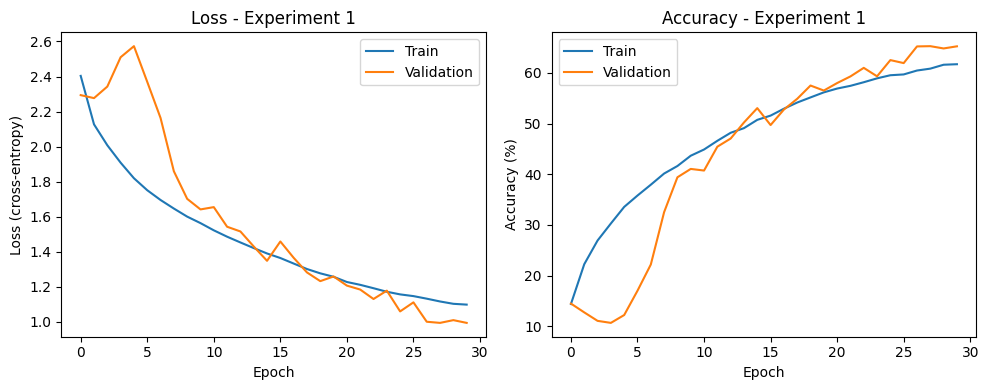


Experiment 1 Test Accuracy: 64.80%


In [85]:
# Learning curves
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title('Loss - Experiment 1')
axes[0].plot(history_exp1['train_loss'], label='Train')
axes[0].plot(history_exp1['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (cross-entropy)')
axes[0].legend(loc='best')

axes[1].set_title('Accuracy - Experiment 1')
axes[1].plot(history_exp1['train_accuracy'], label='Train')
axes[1].plot(history_exp1['val_accuracy'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

# Test accuracy
test_accuracy_exp1, predictions_exp1, true_labels_exp1 = evaluate_model(model_exp1, test_loader_exp1)
print(f'\nExperiment 1 Test Accuracy: {test_accuracy_exp1:.2f}%')

### 1.6. Experiment 1 Observations

**TODO**: Document your findings:
- What architectural changes did you make?
- How did these changes affect the number of parameters?
- Did the model perform better or worse than the baseline?
- What did you observe about training time and convergence?
- Did you notice any overfitting or underfitting?

*Your notes here:*



---

## Experiment 2: Use RGB Images Instead of Grayscale

**Objective**: Compare model performance using full RGB color information versus grayscale.

### 2.1. Load and Preprocess RGB Data

**TODO**: Modify the transform to keep RGB channels (3 channels) instead of converting to grayscale. Update the normalization to use 3 mean and std values.

*Hint*: For RGB, use `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`

In [6]:
# TODO: Modify this transform to use RGB instead of grayscale
transform_exp2 = transforms.Compose([
    v2.RGB(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load training and test datasets with RGB
train_dataset_exp2 = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=True,
    transform=transform_exp2
)

test_dataset_exp2 = datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=True,
    transform=transform_exp2
)

print(f'Image shape: {train_dataset_exp2[0][0].shape}')  # Should be [3, 32, 32]

Image shape: torch.Size([3, 32, 32])


### 2.2. Visualize RGB Sample Images

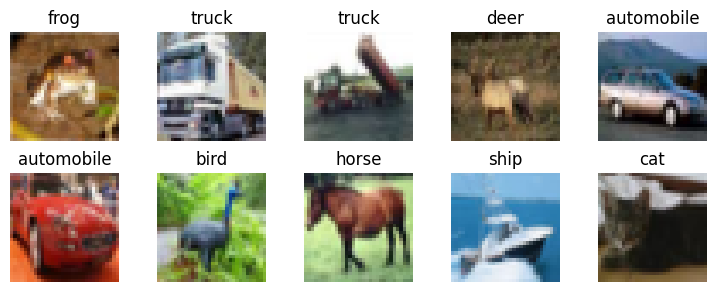

In [7]:
# Plot first 10 RGB images from the training dataset
ncols = 5
nrows = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*1.5, nrows*1.5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img, label = train_dataset_exp2[i]
    
    # Unnormalize and transpose for plotting
    img = img * 0.5 + 0.5
    img = img.numpy().transpose(1, 2, 0)  # Change from CxHxW to HxWxC
    ax.set_title(class_names[label])
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

### 2.3. Create Data Loaders for RGB

In [8]:
# Create training, validation and testing tensors
X_train_full_exp2 = torch.stack([img for img, _ in train_dataset_exp2]).to(device)
y_train_full_exp2 = torch.tensor([label for _, label in train_dataset_exp2]).to(device)

X_test_exp2 = torch.stack([img for img, _ in test_dataset_exp2]).to(device)
y_test_exp2 = torch.tensor([label for _, label in test_dataset_exp2]).to(device)

# Split training data
n_train = int(0.8 * len(X_train_full_exp2))
indices = torch.randperm(len(X_train_full_exp2))

X_train_exp2 = X_train_full_exp2[indices[:n_train]]
y_train_exp2 = y_train_full_exp2[indices[:n_train]]
X_val_exp2 = X_train_full_exp2[indices[n_train:]]
y_val_exp2 = y_train_full_exp2[indices[n_train:]]

# Create DataLoaders
train_tensor_dataset_exp2 = torch.utils.data.TensorDataset(X_train_exp2, y_train_exp2)
val_tensor_dataset_exp2 = torch.utils.data.TensorDataset(X_val_exp2, y_val_exp2)
test_tensor_dataset_exp2 = torch.utils.data.TensorDataset(X_test_exp2, y_test_exp2)

train_loader_exp2 = DataLoader(train_tensor_dataset_exp2, batch_size=batch_size, shuffle=True)
val_loader_exp2 = DataLoader(val_tensor_dataset_exp2, batch_size=batch_size, shuffle=False)
test_loader_exp2 = DataLoader(test_tensor_dataset_exp2, batch_size=batch_size, shuffle=False)

print(f'X_train shape: {X_train_exp2.shape}')  # Should show 3 channels

X_train shape: torch.Size([40000, 3, 32, 32])


### 2.4. Define CNN for RGB Images

**TODO**: Modify the first Conv2d layer to accept 3 input channels instead of 1.

In [ ]:
# Update the first conv layer to accept 3 channels
num_classes = 10
model_exp2 = nn.Sequential(

    # Conv block: RGB input
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.25),

    # Conv block2: RGB input
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.25),

    # Conv block3: RGB input
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.25),
    
    # Classifier
    nn.Flatten(),
    nn.Linear(128 * 4 * 4, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, num_classes)

).to(device)

trainable_params = sum(p.numel() for p in model_exp2.parameters() if p.requires_grad)
print(model_exp2)
print(f'\nTotal parameters: {trainable_params}')

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.25, inplace=False)
  (8): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Dropout(p=0.25, inplace=False)
  (16): Flatten(start_dim=1, end_dim=-1)
  (17)

### 2.5. Train RGB Model

In [16]:
%%time

criterion_exp2 = nn.CrossEntropyLoss()
optimizer_exp2 = optim.Adam(model_exp2.parameters(), lr=learning_rate)

history_exp2 = train_model(
    model=model_exp2,
    train_loader=train_loader_exp2,
    val_loader=val_loader_exp2,
    criterion=criterion_exp2,
    optimizer=optimizer_exp2,
    epochs=epochs,
    print_every=print_every
)

Epoch 1/30 - loss: 2.5259 - accuracy: 14.47% - val_loss: 2.2786 - val_accuracy: 17.68%
Epoch 5/30 - loss: 1.6962 - accuracy: 37.06% - val_loss: 2.0276 - val_accuracy: 21.04%
Epoch 10/30 - loss: 1.3911 - accuracy: 48.98% - val_loss: 1.6417 - val_accuracy: 41.91%
Epoch 15/30 - loss: 1.2135 - accuracy: 56.23% - val_loss: 1.2188 - val_accuracy: 57.12%
Epoch 20/30 - loss: 1.0651 - accuracy: 61.74% - val_loss: 1.0590 - val_accuracy: 62.83%
Epoch 25/30 - loss: 0.9388 - accuracy: 66.72% - val_loss: 0.9240 - val_accuracy: 67.81%
Epoch 30/30 - loss: 0.8549 - accuracy: 69.70% - val_loss: 0.8321 - val_accuracy: 70.91%

Training complete.
CPU times: total: 24min 5s
Wall time: 14min 23s


### 2.6. Evaluate RGB Model

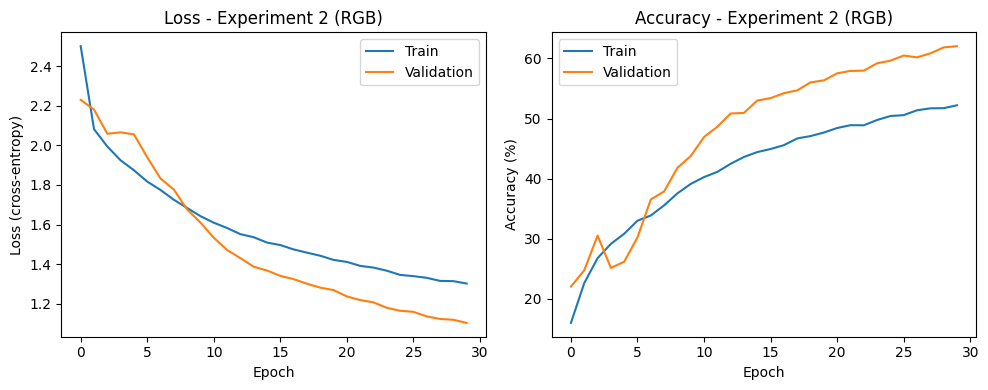


Experiment 2 Test Accuracy: 60.93%


In [25]:
# Learning curves
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title('Loss - Experiment 2 (RGB)')
axes[0].plot(history_exp2['train_loss'], label='Train')
axes[0].plot(history_exp2['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (cross-entropy)')
axes[0].legend(loc='best')

axes[1].set_title('Accuracy - Experiment 2 (RGB)')
axes[1].plot(history_exp2['train_accuracy'], label='Train')
axes[1].plot(history_exp2['val_accuracy'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

# Test accuracy
test_accuracy_exp2, predictions_exp2, true_labels_exp2 = evaluate_model(model_exp2, test_loader_exp2)
print(f'\nExperiment 2 Test Accuracy: {test_accuracy_exp2:.2f}%')

### 2.7. Experiment 2 Observations

**TODO**: Document your findings:
- Did RGB improve accuracy compared to grayscale?
- How did the number of parameters change?
- Which classes benefited most from color information?
- Were there any classes that performed similarly with both grayscale and RGB?

*Your notes here:*



---

## Experiment 3: Add Image Augmentation

**Objective**: Use PyTorch transforms to augment training data and improve model generalization.

### 3.1. Define Augmented Transforms

**TODO**: Add image augmentation transforms to the training data. Consider:
- `transforms.RandomHorizontalFlip(p=0.5)` - Randomly flip images horizontally
- `transforms.RandomCrop(32, padding=4)` - Random crop with padding
- `transforms.RandomRotation(degrees=15)` - Small random rotations
- `transforms.ColorJitter(brightness=0.2, contrast=0.2)` - Random brightness/contrast adjustments

**Note**: Apply augmentation only to training data, not validation or test data!

In [ ]:
# TODO: Add augmentation transforms here
transform_train_exp3 = transforms.Compose([
    # TODO: Add augmentation transforms here (before ToTensor)    
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Validation and test transforms (no augmentation)
transform_test_exp3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets with augmentation
train_dataset_exp3 = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=True,
    transform=transform_train_exp3  # Augmented transform
)

test_dataset_exp3 = datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=True,
    transform=transform_test_exp3  # No augmentation
)

print('Datasets loaded with augmentation')

### 3.2. Visualize Augmented Images

Run this cell multiple times to see different augmentations of the same images!

In [ ]:
# Visualize augmented versions of the same images
ncols = 5
nrows = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*1.5, nrows*1.5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    # Get augmented version each time this is run
    img, label = train_dataset_exp3[i]
    
    # Unnormalize and transpose for plotting
    img = img * 0.5 + 0.5
    img = img.numpy().transpose(1, 2, 0)
    ax.set_title(class_names[label])
    ax.imshow(img)
    ax.axis('off')

plt.suptitle('Augmented Training Images (run cell again to see different augmentations)', y=1.02)
plt.tight_layout()
plt.show()

### 3.3. Create Data Loaders with Augmentation

In [ ]:
# For data augmentation, we must NOT preload data to GPU as tensors.
# Transforms need to be applied on-the-fly during each epoch so each 
# batch sees different augmented versions of the images.

# Split training data into train and validation sets using Subset
n_train = int(0.8 * len(train_dataset_exp3))
n_val = len(train_dataset_exp3) - n_train
indices = torch.randperm(len(train_dataset_exp3)).tolist()

train_subset_exp3 = torch.utils.data.Subset(train_dataset_exp3, indices[:n_train])
val_subset_exp3 = torch.utils.data.Subset(train_dataset_exp3, indices[n_train:])

print(f'Training samples: {len(train_subset_exp3)}')
print(f'Validation samples: {len(val_subset_exp3)}')
print(f'Test samples: {len(test_dataset_exp3)}')

In [ ]:
# Create DataLoaders directly from Dataset/Subset objects
# Transforms are applied on-the-fly when batches are loaded
train_loader_exp3 = DataLoader(
    train_subset_exp3,
    batch_size=batch_size,
    shuffle=True
)

val_loader_exp3 = DataLoader(
    val_subset_exp3,
    batch_size=batch_size,
    shuffle=False
)

test_loader_exp3 = DataLoader(
    test_dataset_exp3,
    batch_size=batch_size,
    shuffle=False
)

print(f'Training batches: {len(train_loader_exp3)}')
print(f'Validation batches: {len(val_loader_exp3)}')
print(f'Test batches: {len(test_loader_exp3)}')

### 3.4. Define Model for Augmented Data

In [ ]:
# Same architecture as Experiment 2 (RGB)
model_exp3 = nn.Sequential(

    # Conv block: RGB input
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.5),
    
    # Classifier
    nn.Flatten(),
    nn.Linear(32 * 16 * 16, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes)

).to(device)

trainable_params = sum(p.numel() for p in model_exp3.parameters() if p.requires_grad)
print(f'Total parameters: {trainable_params}')

### 3.5. Train Model with Augmented Data

In [ ]:
%%time

criterion_exp3 = nn.CrossEntropyLoss()
optimizer_exp3 = optim.Adam(model_exp3.parameters(), lr=learning_rate)

# Pass device to move batches on-the-fly (required for on-the-fly augmentation)
history_exp3 = train_model(
    model=model_exp3,
    train_loader=train_loader_exp3,
    val_loader=val_loader_exp3,
    criterion=criterion_exp3,
    optimizer=optimizer_exp3,
    epochs=epochs,
    print_every=print_every,
    device=device
)

### 3.6. Evaluate Augmented Model

In [ ]:
# Learning curves
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title('Loss - Experiment 3 (Augmented)')
axes[0].plot(history_exp3['train_loss'], label='Train')
axes[0].plot(history_exp3['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (cross-entropy)')
axes[0].legend(loc='best')

axes[1].set_title('Accuracy - Experiment 3 (Augmented)')
axes[1].plot(history_exp3['train_accuracy'], label='Train')
axes[1].plot(history_exp3['val_accuracy'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

# Test accuracy (pass device for on-the-fly batch loading)
test_accuracy_exp3, predictions_exp3, true_labels_exp3 = evaluate_model(
    model_exp3, test_loader_exp3, device=device
)
print(f'\nExperiment 3 Test Accuracy: {test_accuracy_exp3:.2f}%')

### 3.7. Experiment 3 Observations

**TODO**: Document your findings:
- Which augmentation techniques did you use?
- Did augmentation improve test accuracy?
- Did you notice any effect on the gap between training and validation accuracy (overfitting)?
- How did training time compare to non-augmented training?
- Would you recommend augmentation for this dataset?

*Your notes here:*



---

## Summary: Compare All Experiments

### Compare Test Accuracies

**TODO**: Fill in your results and compare:

| Experiment | Description | Test Accuracy | Notes |
|------------|-------------|---------------|-------|
| Baseline (demo) | Grayscale, simple architecture | ~60% | From demo notebook |
| Experiment 1 | Modified architecture | _% | |
| Experiment 2 | RGB images | _% | |
| Experiment 3 | Image augmentation | _% | |

### Final Reflections

**TODO**: Based on your experiments, answer these questions:

1. Which experiment produced the best results and why do you think that is?

2. What trade-offs did you observe between model complexity, training time, and performance?

3. If you were to combine multiple improvements (e.g., deeper architecture + RGB + augmentation), what would you expect?

4. What other experiments would you like to try?

*Your reflections here:*

